# New York City Taxi Trip Duration: Exploratory Data Analysis

_By [Michael Rosenberg](mailto:rosenberg.michael.m@gmail.com)._

_**Description**: Contains my EDA for the [New York City Taxi Trip Duration Competition](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)._

_Last Updated: 9/5/2017 7:01 PM._

In [73]:
#imports
import pandas as pd
import numpy as np
from bokeh.charts import Bar, Histogram, TimeSeries, output_file, show
from bokeh.io import output_notebook
from bokeh.models import (
    GMapPlot, GMapOptions, ColumnDataSource, Circle, DataRange1d, PanTool, 
    WheelZoomTool, BoxSelectTool, HoverTool,
    ResizeTool, SaveTool, CrosshairTool
)
from bokeh.charts.attributes import CatAttr, ColorAttr
from bokeh.plotting import figure, output_file, show
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp

#helpers
%matplotlib inline
sns.set_style("whitegrid")
output_notebook()
sigLev = 3
percentLev = 100
alphaLev = .2
binCount = 30
pd.set_option("display.precision",sigLev)

Loading BokehJS ...

In [48]:
#load in data
trainFrame = pd.read_csv("../data/raw/train.csv")
testFrame = pd.read_csv("../data/raw/test.csv")

In [49]:
print(trainFrame.shape)
print(testFrame.shape)

(1458644, 11)
(625134, 9)


We see that we have over double the size of the test set inside our training set. This suggests that generating a validation set won't be unreasonable for this competition.

# Univariate Relationships

In [50]:
trainFrame.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'dropoff_datetime',
       u'passenger_count', u'pickup_longitude', u'pickup_latitude',
       u'dropoff_longitude', u'dropoff_latitude', u'store_and_fwd_flag',
       u'trip_duration'],
      dtype='object')

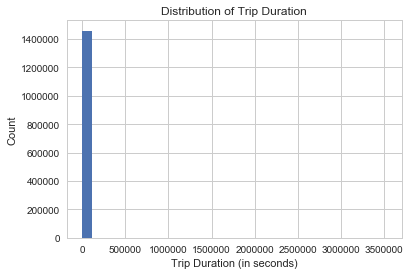

In [51]:
plt.hist(trainFrame["trip_duration"],bins = binCount)
plt.xlabel("Trip Duration (in seconds)")
plt.ylabel("Count")
plt.title("Distribution of Trip Duration")

_Figure 1: Distribution of Trip Duration (in seconds)._

We see a significantly right-skewed distribution. This suggests to me that we will have a situation where it will be reasonable to calculate some of the shorter trips, but we will have error dragged down by some extremely long trip durations.

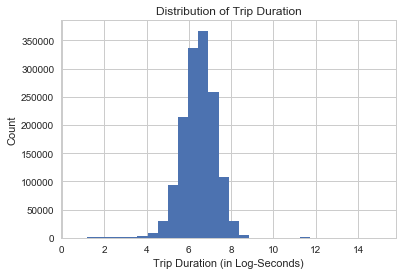

In [52]:
trainFrame["logTripDuration"] = np.log(trainFrame["trip_duration"] + 1)
plt.hist(trainFrame["logTripDuration"],bins = binCount)
plt.xlabel("Trip Duration (in Log-Seconds)")
plt.ylabel("Count")
plt.title("Distribution of Trip Duration")

_Figure 2: Distribution of Trip Duration (in log-seconds)._

Interestingly, when we log this variable, we have a much more reasonable distribution to work this, one that is approximately normal. Thus, it might be useful to consider predicting in the log-seconds space and then transforming our predictions to the seconds space. We can try both options for our modeling purposes.

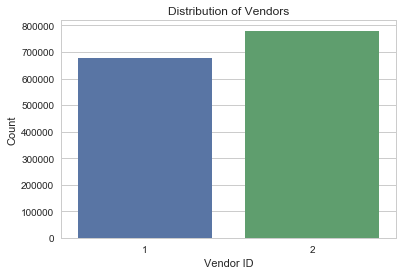

In [53]:
#analyze vendors
vendorCountFrame = trainFrame.groupby("vendor_id",as_index = False)[
                                                                "id"].count()
vendorCountFrame = vendorCountFrame.rename(columns = {"id":"count"})
#then plot
sns.barplot(x = "vendor_id",y = "count",data = vendorCountFrame)
plt.xlabel("Vendor ID")
plt.ylabel("Count")
plt.title("Distribution of Vendors")

_Figure 3: Distribution of Vendors._

We see that we only have two vendors in this dataset. We also see that vendor 2 is rather more present in the dataset than vendor 1.

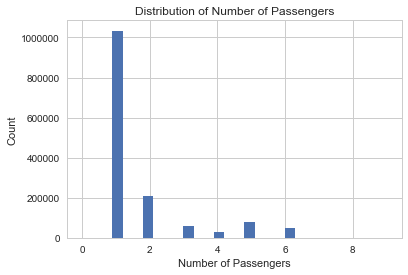

In [54]:
plt.hist(trainFrame["passenger_count"],bins = binCount)
plt.xlabel("Number of Passengers")
plt.ylabel("Count")
plt.title("Distribution of Number of Passengers")

_Figure 4: Distribution of Number of Passengers._

We see that most taxis are taking only one passenger. The distribution of this variable suggests that a reasonable encoding might be to consider a dummy encoding of "only one passenger" vs. more than one passsenger.

In [55]:
#make our datetime objects
trainFrame["pickup_datetime"] = pd.to_datetime(trainFrame["pickup_datetime"])
trainFrame["dropoff_datetime"] = pd.to_datetime(trainFrame["dropoff_datetime"])

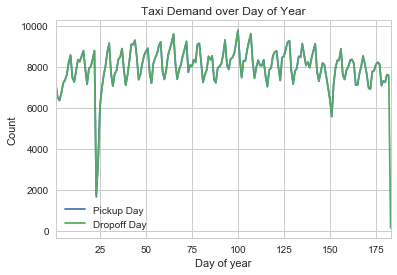

In [56]:
#check distribution of days
trainFrame["pickup_dayofyear"] = trainFrame["pickup_datetime"].dt.dayofyear
trainFrame["dropoff_dayofyear"] = trainFrame["dropoff_datetime"].dt.dayofyear
#then plot counts for each
pickupDayCountSeries = trainFrame.groupby("pickup_dayofyear")["id"].count()
dropoffDayCountSeries = trainFrame.groupby("dropoff_dayofyear")["id"].count()
#plot
pickupDayCountSeries.plot(label = "Pickup Day")
dropoffDayCountSeries.plot(label = "Dropoff Day")
plt.legend()
plt.xlabel("Day of year")
plt.ylabel("Count")
plt.title("Taxi Demand over Day of Year")

_Figure 5: Taxi Demand over Day of Year._

We recognize somewhat of a cyclical trend in the demand of taxis over the year; there isn't too much of a deviation from the average, but that deviation is systematic. My guess is that demand varies based on the day of the week.

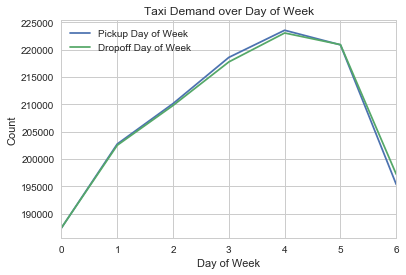

In [57]:
#check distribution of day of week
trainFrame["pickup_dayofweek"] = trainFrame["pickup_datetime"].dt.dayofweek
trainFrame["dropoff_dayofweek"] = trainFrame["dropoff_datetime"].dt.dayofweek
#then plot counts for each
pickupDayCountSeries = trainFrame.groupby("pickup_dayofweek")["id"].count()
dropoffDayCountSeries = trainFrame.groupby("dropoff_dayofweek")["id"].count()
#plot
pickupDayCountSeries.plot(label = "Pickup Day of Week")
dropoffDayCountSeries.plot(label = "Dropoff Day of Week")
plt.legend()
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.title("Taxi Demand over Day of Week")

_Figure 6: Taxi Demand over day of Week._

We notice a clear trend in this context: Demand peaks on Friday (Day of Week $= 4$), and cycles back down to a low on Monday (Day of Week $= 0$.) It will be useful to tell if this ariable is at all correlated with length of ride, since taxi demand may be correlated with traffic on the roads.

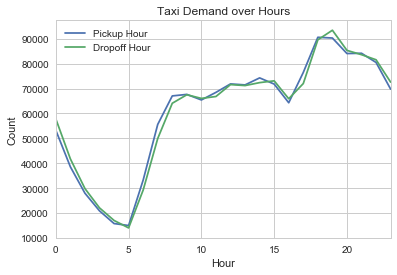

In [58]:
#check distribution of hour
trainFrame["pickup_hour"] = trainFrame["pickup_datetime"].dt.hour
trainFrame["dropoff_hour"] = trainFrame["dropoff_datetime"].dt.hour
#then plot counts for each
pickupDayCountSeries = trainFrame.groupby("pickup_hour")["id"].count()
dropoffDayCountSeries = trainFrame.groupby("dropoff_hour")["id"].count()
#plot
pickupDayCountSeries.plot(label = "Pickup Hour")
dropoffDayCountSeries.plot(label = "Dropoff Hour")
plt.legend()
plt.xlabel("Hour")
plt.ylabel("Count")
plt.title("Taxi Demand over Hours")

_Figure 7: Taxi Demand over hour._

It is also clear that taxi demand varies based on the hour of the day. Generally traffic looks to be the lowest in the early morning, and the highest in the late evening. This will be an important variable to study in order to calculate time it will take to reach one's destination.

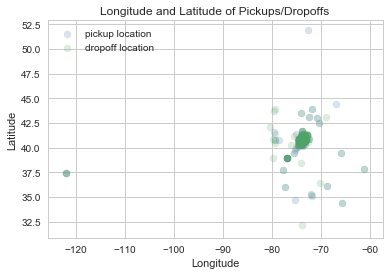

In [96]:
plt.scatter(trainFrame["pickup_longitude"],trainFrame["pickup_latitude"],
            alpha = alphaLev,label = "pickup location")
plt.scatter(trainFrame["dropoff_longitude"],trainFrame["dropoff_latitude"],
            alpha = alphaLev,label = "dropoff location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Longitude and Latitude of Pickups/Dropoffs")
plt.legend()

_Figure 8: Latitude and Longitude of Pickups and Dropoffs._

We notice some severe outliers informing our analysis in these dimensions. Let us see if we can filter these outliers in order to get a better sense of this plot.

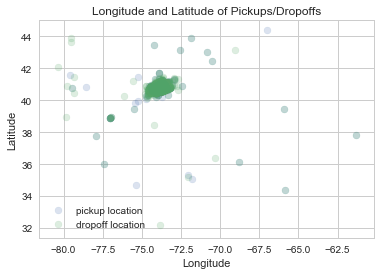

In [88]:
filteredTrainFrame = trainFrame[(trainFrame["pickup_longitude"] > -100) &
                                (trainFrame["dropoff_longitude"] > -100) &
                                (trainFrame["pickup_latitude"] < 50) &
                                (trainFrame["dropoff_latitude"] < 50)]
#then plot
plt.scatter(filteredTrainFrame["pickup_longitude"],
            filteredTrainFrame["pickup_latitude"],
            alpha = alphaLev,label = "pickup location")
plt.scatter(filteredTrainFrame["dropoff_longitude"],
            filteredTrainFrame["dropoff_latitude"],
            alpha = alphaLev,label = "dropoff location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Longitude and Latitude of Pickups/Dropoffs")
plt.legend()

_Figure 9: Latitude and Longitude of Pickups and Dropoffs, Guardrailed._

Let's filter even further.

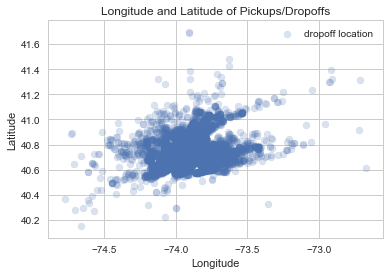

In [90]:
filteredTrainFrame = trainFrame[(trainFrame["dropoff_longitude"] > -75) &
                                (trainFrame["dropoff_longitude"] < -72.5) &
                                (trainFrame["dropoff_latitude"] < 42) &
                                (trainFrame["dropoff_latitude"] > 40)]
#then plot
plt.scatter(filteredTrainFrame["dropoff_longitude"],
            filteredTrainFrame["dropoff_latitude"],
            alpha = alphaLev,label = "dropoff location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Longitude and Latitude of Pickups/Dropoffs")
plt.legend()

_Figure 10: Latitude and Longitude of Dropoffs, Guardrailed._

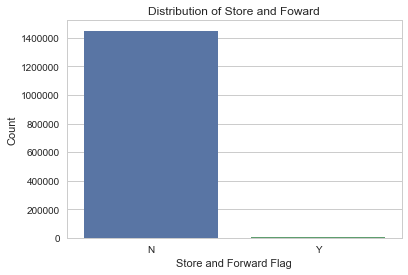

In [64]:
storeFlagCountFrame = trainFrame.groupby("store_and_fwd_flag",as_index = False)[
                                            "id"].count()
storeFlagCountFrame = storeFlagCountFrame.rename(columns = {"id":"count"})
#then plot
sns.barplot(x = "store_and_fwd_flag",y = "count",data = storeFlagCountFrame)
plt.xlabel("Store and Forward Flag")
plt.ylabel("Count")
plt.title("Distribution of Store and Foward")

_Figure 11: Distribution of the Store and Forward Variable._

This occurs so not often, it is likely that this variable is not too important for fitting an initial model.

# Bivariate Relationships

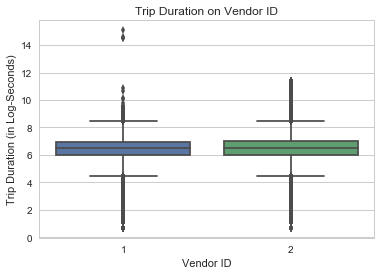

In [67]:
sns.boxplot(x = "vendor_id",y = "logTripDuration",data = trainFrame)
plt.xlabel("Vendor ID")
plt.ylabel("Trip Duration (in Log-Seconds)")
plt.title("Trip Duration on Vendor ID")

_Figure 12: Trip Duration (in Log-Seconds) on Vendor ID._

It is apparent that the vendor ID is having minimal effect on the trip duration overall.

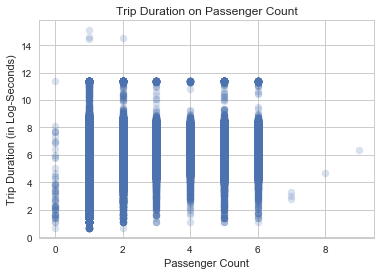

In [74]:
plt.scatter(trainFrame["passenger_count"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("Passenger Count")
plt.ylabel("Trip Duration (in Log-Seconds)")
plt.title("Trip Duration on Passenger Count")

_Figure 13: Trip Duration on Passenger Count._

We see minimal effect of passenger countm except that trips with less than 1 passenger generally take a shorter time than those with more passengers. This isn't a very surprising result, but it might be useful if we wanted to fit the unusual observation of having no passengers in the vehicle.

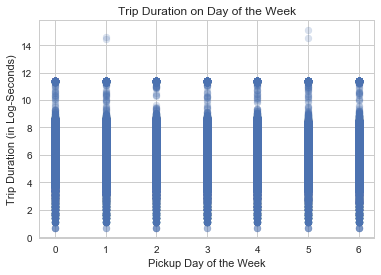

In [76]:
plt.scatter(trainFrame["pickup_dayofweek"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("Pickup Day of the Week")
plt.ylabel("Trip Duration (in Log-Seconds)")
plt.title("Trip Duration on Day of the Week")

_Figure 14: Trip Duration on Day of the Week of Pickup._

Interestingly, this variable seems to have little effect on trip duration. That being said, it might be useful to fit with this variable for exploratory purposes.

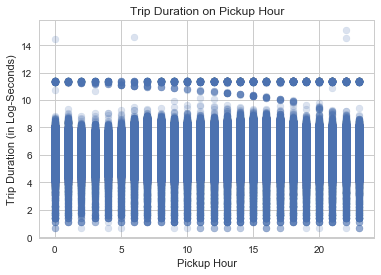

In [79]:
plt.scatter(trainFrame["pickup_hour"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("Pickup Hour")
plt.ylabel("Trip Duration (in Log-Seconds)")
plt.title("Trip Duration on Pickup Hour")

_Figure 15: Trip Duration on Pickup Hour._

So far, we have seen little correlation between trip duration and time of pickup, Perhaps we need to study the interaction between day of week and pickup hour to get a stronger sense of the relationship.

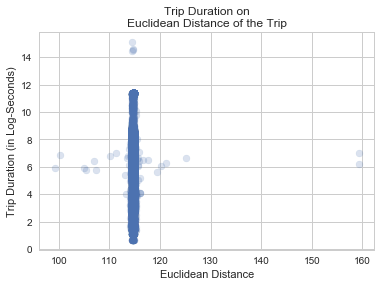

In [83]:
#get euclidean distance between pickup and dropoff
trainFrame["euclidDist"] = np.sqrt((trainFrame["pickup_latitude"]
                                   -trainFrame["dropoff_latitude"]) ** 2 +
                                   (trainFrame["pickup_longitude"]
                                   -trainFrame["pickup_latitude"]) ** 2)
#then plot relationship
plt.scatter(trainFrame["euclidDist"],trainFrame["logTripDuration"],
            alpha = alphaLev)
plt.xlabel("Euclidean Distance")
plt.ylabel("Trip Duration (in Log-Seconds)")
plt.title("Trip Duration on\nEuclidean Distance of the Trip")

_Figure 16: Trip Duration on Euclidean Distance of the trip._

We notice very little variance in Euclidean distance of the trip. Thus, it is difficult to point to a component of trip duration that is informed by Euclidean Distance of the trip.

# Conclusions

* So far, there looks to be very few direct effects. Thus, it'll be important for us to mine certain interaction effects within our initial modeling. These interactions so far may be built on intuition over the EDA.

* I think the best way to encode the effect of pickup and dropoff point will be through a tile encoding over the space. How big those tiles will be will need to be tuned.

# FIX

* Need to make Bokeh Library work!